#Make a comparison of supervised DNN models for Cifar100 dataset


#Steps


Step 1: Check the overfit

Step 2: Check the accuracy and loss for validation and test set





First of all,we transform the indexes of our data (y_train), wich are loaded from Cifar 100 from range of 1 to 100 to range 1 to nymber of classes. That will help us in the output layer in order that the outputs are equal to our classes.

In [ ]:
j=1
for i in range(1,100):
  if i in y_train:
   y_train_ds[np.where(y_train_ds==i)]=j
   y_test_ds[np.where(y_test_ds==i)]=j
   j=j+1

x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

Then we will apply data augmentation will be used with the aim of reducing overfit. We will create a total of 8460 new images that come from our training set and will be added to it. After a lot of testing and thinking about the simplicity of the data we want to keep with different types of image transformations we ended up with rotation from 1 to 360 degrees, shear from 0 to 0.2 and random horizontal rotation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 360,
    shear_range = 0.2,
    horizontal_flip = True)
datagen.fit(x_train)
t_img= datagen.flow(x_train, y_train, batch_size=8460)
x_train=np.concatenate((t_img[0][0],x_train))
y_train=np.concatenate((t_img[0][1],y_train))

The above steps helped quite a bit both in reducing overfit and increasing accuracy. Nevertheless, it was not enough, it required both a change in the architecture and a reduction of the batch size from 128 to 64.

In [ ]:
BATCH_SIZE = 64
train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

Below is the optimal model of the previous query with the input of the new data and the goal of reducing overfit. Added Dropout and BatchNormalization layers where deemed necessary. We increase the epoch steps and 23 the validation steps, their value was chosen as follows (data size)/(batch size) .

##Softmax

We chose the model with the SGD optimizer. Wherever we added a Dropout layer with a rate of 0.125. The overfit remains low as do the accuracies of the two categories which remain almost the same.

In [ ]:
def model_Softmax(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dropout(rate = 0.125))
  model.add(layers.Dense(200, activation='softmax'))
  model.compile(optimizer=tf.optimizers.SGD(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary:
    model.summary()
  return model

In [ ]:
MODEL_Softmax = model_Softmax(summary = True)
MODEL_Softmax_history = train_model(MODEL_Softmax, 150, 50, 23)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
50/50 [==============================] - 0s 7ms/step - loss: 3.5587 - accuracy: 0.0659 - val_loss: 3.0487 - val_accuracy: 0.1005
Epoch 2/150
50/50 [==============================] - 0s 5ms/step - loss: 3.0146 - accuracy: 0.1153 - val_loss: 2.8643 - val_accuracy: 0.1535
Epoch 3/150
50/50 [==============================] - 0s 5ms/step - loss: 2.8627 - accuracy: 0.14

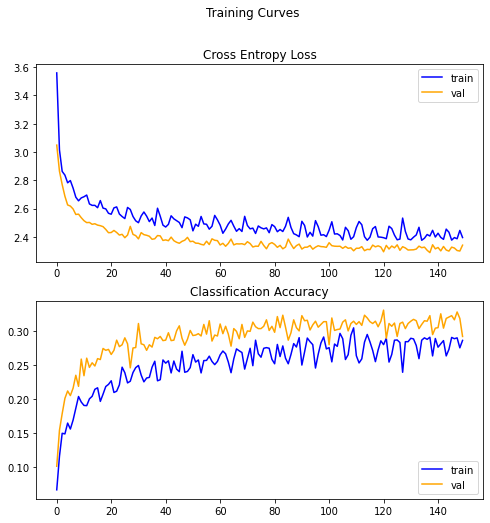


Test set evaluation metrics
5/5 [==============================] - 0s 3ms/step - loss: 2.4057 - accuracy: 0.2875
loss: 2.41
accuracy: 0.29


In [ ]:
model_report(MODEL_Softmax, MODEL_Softmax_history, 5)

##MLP

We select the model with the Adam optimizer and add two Dropout layers at a rate of 1/4. There is no change in the values ​​of the metrics, nor is there any overfit, which was the goal.

In [ ]:
def model_MLP(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Dense(200, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary:
     model.summary()
  return model

In [ ]:
MODEL_MLP = model_MLP(summary = True)
MODEL_MLP_history = train_model(MODEL_MLP, 150, 265, 23)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               1573376   
_________________________________________________________________
flatten_28 (Flatten)         (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
___________________________________________

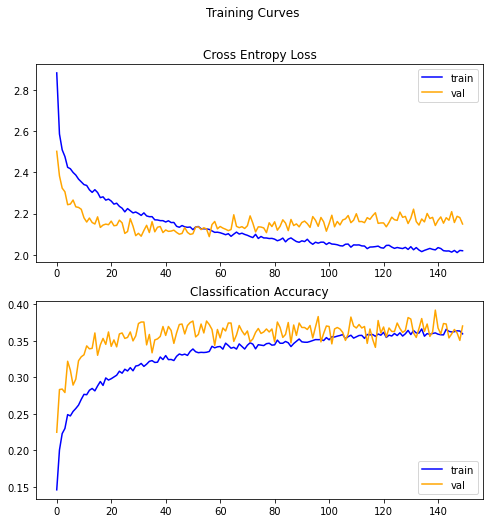


Test set evaluation metrics
5/5 [==============================] - 0s 3ms/step - loss: 2.0990 - accuracy: 0.3750
loss: 2.10
accuracy: 0.38


In [ ]:
model_report(MODEL_MLP, MODEL_MLP_history, 5)

##LeNet

We select the model with the Adam optimizer and added Dropout layers. The accuracy value increased for the test set to 64% and for the validation set to 60% and overfit decreased.

In [ ]:
def model_LeNet(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Dense(200, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary:
      model.summary()
  return model

In [ ]:
MODEL_LeNet = model_LeNet(summary = True)
MODEL_LeNet_history = train_model(MODEL_LeNet, 150, 265, 23)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)         

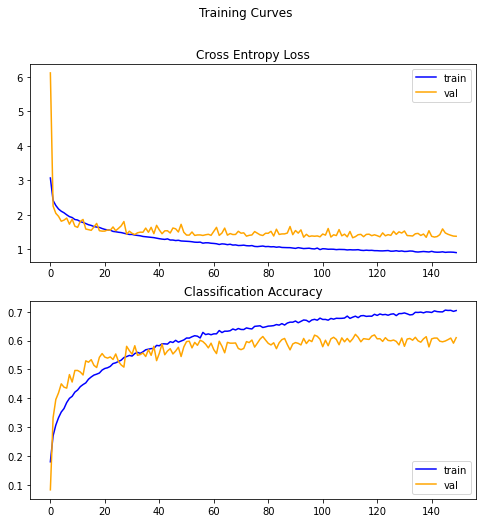


Test set evaluation metrics
5/5 [==============================] - 0s 4ms/step - loss: 1.5471 - accuracy: 0.5969
loss: 1.55
accuracy: 0.60


In [ ]:
model_report(MODEL_LeNet, MODEL_LeNet_history, 5)

##CNN1

We create a model with the Adam optimizer and added Dropout layers. The accuracy value increased for the test set to 56% and for the validation set to 61% and the overfit decreased.

In [ ]:
def model_CNN1(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(16, (5, 5), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Conv2D(16, (3, 3),padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Dense(200, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary:
      model.summary()
  return model
from keras.layers import BatchNormalization

In [ ]:
MODEL_CNN1 = model_CNN1(summary = True)
MODEL_CNN1_history = train_model(MODEL_CNN1, 150, 265, 23)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 16)        

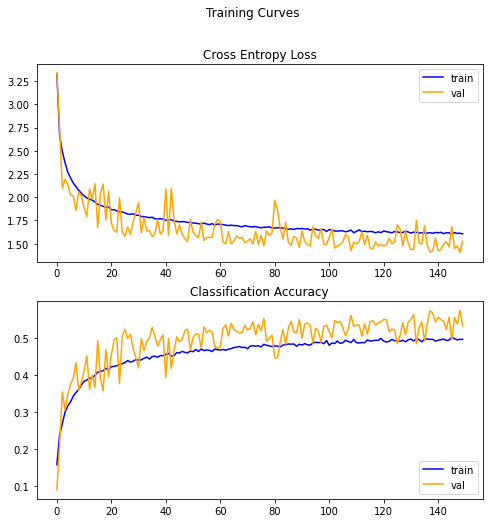


Test set evaluation metrics
5/5 [==============================] - 0s 4ms/step - loss: 1.4044 - accuracy: 0.6062
loss: 1.40
accuracy: 0.61


In [ ]:
model_report(MODEL_CNN1, MODEL_CNN1_history, 5)

##CNN2

We create a model with the Adam optimizer and added Dropout layers. The accuracy value increased for the test set in % and for the validation set in % and loss < 1. This model is the best in terms of overfit and metrics

In [ ]:
def model_CNN2(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), padding='same', activation="relu",use_bias=False ,input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.125))
  model.add(layers.Conv2D(64, (3, 3),padding='same', activation="relu" ,use_bias=False ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Conv2D(64, (3, 3),padding='same', activation="relu",use_bias=False ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation="relu",use_bias=False ))
  model.add(layers.Dropout(rate = 0.5))
  model.add(layers.Dense(21, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary:
    model.summary()
  return model

In [ ]:
MODEL_CNN2 = model_CNN2(summary = True)
MODEL_CNN2_history = train_model(MODEL_CNN2, 500, 265, 23)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18432     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)         

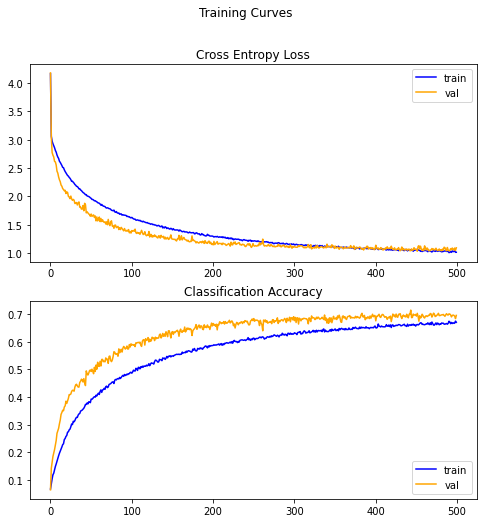


Test set evaluation metrics
5/5 [==============================] - 0s 4ms/step - loss: 0.9848 - accuracy: 0.7125
loss: 0.98
accuracy: 0.71


In [ ]:
model_report(MODEL_CNN2, MODEL_CNN2_history, 5)

#Test Set -Loss -Acuracy

In [ ]:
print('\Softmax')
loss0,accuracy0 = MODEL_Softmax.evaluate(x_test, y_test, batch_size=128)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))


print('\MLP')
loss0,accuracy0 = MODEL_MLP.evaluate(x_test, y_test, batch_size=128)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))


print('\LeNet')
loss0,accuracy0 = MODEL_LeNet.evaluate(x_test, y_test, batch_size=128)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))


print('\CNN1')
loss0,accuracy0 = MODEL_CNN1.evaluate(x_test, y_test, batch_size=128)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

print('\CNN2')
loss0,accuracy0 = MODEL_CNN2.evaluate(x_test, y_test, batch_size=128)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

\Softmax
16/16 [==============================] - 0s 4ms/step - loss: 2.4713 - accuracy: 0.2790
loss: 2.47
accuracy: 0.28
\MLP
16/16 [==============================] - 0s 4ms/step - loss: 2.0989 - accuracy: 0.3905
loss: 2.10
accuracy: 0.39
\LeNet
16/16 [==============================] - 0s 6ms/step - loss: 1.3177 - accuracy: 0.6355
loss: 1.32
accuracy: 0.64
\CNN1
16/16 [==============================] - 0s 6ms/step - loss: 1.4695 - accuracy: 0.5620
loss: 1.47
accuracy: 0.56
\CNN2
16/16 [==============================] - 0s 7ms/step - loss: 1.0183 - accuracy: 0.7055
loss: 1.02
accuracy: 0.71
